In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.preprocessing import StandardScaler, RobustScaler
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import warnings
warnings.filterwarnings('ignore')

# ========================================================================================
# STACKING ARCHITECTURE COMPARISON
# Architecture 1: Full Chain (all 4 targets)
# Architecture 2: Hybrid (chain for 3 + separate 6-month)
# ========================================================================================

recession_targets = [
    "recession_probability",
    "1_month_recession_probability", 
    "3_month_recession_probability",
    "6_month_recession_probability",
]

chain_targets = recession_targets[:3]
target_6m = recession_targets[3]

# -------------------------
# Data Preparation (same as before)
# -------------------------
def prepare_data(df, split_date="2020-01-01"):
    df["date"] = pd.to_datetime(df["date"])
    train_df = df[df["date"] < split_date].copy()
    test_df = df[df["date"] >= split_date].copy()
    
    X_train = train_df.drop(columns=recession_targets + ["date"])
    X_test = test_df.drop(columns=recession_targets + ["date"])
    y_train = train_df[recession_targets]
    y_test = test_df[recession_targets]
    
    return X_train, X_test, y_train, y_test, test_df

def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    
    if hasattr(X_or_y, 'select_dtypes'):
        numeric_cols = X_or_y.select_dtypes(include=[np.number]).columns
        X_or_y[numeric_cols] = X_or_y[numeric_cols].fillna(X_or_y[numeric_cols].median())
    else:
        X_or_y = X_or_y.fillna(X_or_y.median())
    
    return X_or_y

def sanitize_columns(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

# -------------------------
# Transformation Functions
# -------------------------
epsilon = 1e-8

def safe_logit_transform(y):
    y_clipped = np.clip(y, 0, 100)
    y_scaled = y_clipped / 100.0
    y_scaled = np.clip(y_scaled, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def safe_inv_logit_transform(y_logit):
    y_logit_clipped = np.clip(y_logit, -50, 50)
    y_prob = 1 / (1 + np.exp(-y_logit_clipped))
    return np.clip(y_prob * 100, 0, 100)

# -------------------------
# Base Model Wrappers
# -------------------------
class LGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, params=None, num_boost_round=500, early_stopping_rounds=50):
        self.params = params or {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 6,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 20,
            "reg_alpha": 0.1,
            "reg_lambda": 0.1,
            "seed": 42,
            "verbose": -1,
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.model = None

    def fit(self, X, y):
        val_size = max(10, int(0.1 * len(X)))
        train_X, val_X = X[:-val_size], X[-val_size:]
        train_y, val_y = y[:-val_size], y[-val_size:]
        
        dtrain = lgb.Dataset(train_X, label=train_y)
        dval = lgb.Dataset(val_X, label=val_y, reference=dtrain)
        
        self.model = lgb.train(
            self.params, 
            dtrain, 
            num_boost_round=self.num_boost_round,
            valid_sets=[dval],
            callbacks=[lgb.early_stopping(self.early_stopping_rounds, verbose=False)]
        )
        return self

    def predict(self, X):
        return self.model.predict(X)

# ========================================================================================
# ARCHITECTURE 1: FULL CHAIN (ALL 4 TARGETS)
# ========================================================================================

class FullChainCatBoostModel:
    """CatBoost with RegressorChain for ALL 4 targets"""
    def __init__(self):
        self.chain_model = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Transform all 4 targets
        y_train_transformed = safe_logit_transform(y_train[recession_targets].values)
        
        # Single chain for all 4 targets: 0 → 1 → 2 → 3
        base_model = CatBoostRegressor(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            subsample=0.8,
            random_seed=42,
            loss_function="RMSE",
            verbose=False
        )
        
        self.chain_model = RegressorChain(base_model, order=[0, 1, 2, 3])
        self.chain_model.fit(X_train_scaled, y_train_transformed)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_logit = self.chain_model.predict(X_test_scaled)
        preds = safe_inv_logit_transform(preds_logit)
        
        return np.clip(preds, 0, 100)

class FullChainLightGBMModel:
    """LightGBM with RegressorChain for ALL 4 targets"""
    def __init__(self):
        self.chain_model = None
        self.scaler = None
        self.lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 8,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 30,
            "reg_alpha": 0.3,
            "reg_lambda": 0.3,
            "seed": 42,
            "verbose": -1,
        }
        
    def fit(self, X_train, y_train):
        X_train = sanitize_columns(X_train)
        
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Transform all 4 targets
        y_train_transformed = safe_logit_transform(y_train[recession_targets].values)
        
        # Single chain for all 4 targets
        chain_base = LGBMWrapper(params=self.lgb_params, num_boost_round=500)
        self.chain_model = RegressorChain(chain_base, order=[0, 1, 2, 3])
        self.chain_model.fit(X_train_scaled, y_train_transformed)
        
    def predict(self, X_test):
        X_test = sanitize_columns(X_test)
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_logit = self.chain_model.predict(X_test_scaled)
        preds = safe_inv_logit_transform(preds_logit)
        
        return np.clip(preds, 0, 100)

class FullChainRandomForestModel:
    """Random Forest with RegressorChain for ALL 4 targets"""
    def __init__(self):
        self.chain_model = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        self.scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Transform all 4 targets
        y_train_transformed = safe_logit_transform(y_train[recession_targets].values)
        
        rf_base = RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.chain_model = RegressorChain(base_estimator=rf_base, order=[0, 1, 2, 3])
        self.chain_model.fit(X_train_scaled, y_train_transformed)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_logit = self.chain_model.predict(X_test_scaled)
        preds = safe_inv_logit_transform(preds_logit)
        
        return np.clip(preds, 0, 100)

# ========================================================================================
# ARCHITECTURE 2: HYBRID (CHAIN FOR 3 + SEPARATE 6-MONTH)
# ========================================================================================

class HybridCatBoostModel:
    """CatBoost with hybrid architecture (your current approach)"""
    def __init__(self):
        self.chain_model = None
        self.model_6m = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Stage 1: Chain for first 3 targets
        y_train_chain = safe_logit_transform(y_train[chain_targets].values)
        
        base_model = CatBoostRegressor(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            subsample=0.8,
            random_seed=42,
            loss_function="RMSE",
            verbose=False
        )
        
        self.chain_model = RegressorChain(base_model, order=[0, 1, 2])
        self.chain_model.fit(X_train_scaled, y_train_chain)
        
        # Stage 2: Separate model for 6-month target
        X_train_6m = X_train_scaled.copy()
        chain_preds = safe_inv_logit_transform(self.chain_model.predict(X_train_scaled))
        X_train_6m[chain_targets] = chain_preds
        y_train_6m = safe_logit_transform(y_train[target_6m].values)
        
        val_size = max(10, int(0.15 * len(X_train_6m)))
        X_train_6m_train = X_train_6m[:-val_size]
        X_train_6m_val = X_train_6m[-val_size:]
        y_train_6m_train = y_train_6m[:-val_size]
        y_train_6m_val = y_train_6m[-val_size:]
        
        self.model_6m = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=8,
            l2_leaf_reg=5,
            subsample=0.8,
            random_seed=42,
            loss_function="RMSE",
            early_stopping_rounds=100,
            verbose=False,
            use_best_model=True
        )
        
        train_pool_6m = Pool(X_train_6m_train, y_train_6m_train)
        val_pool_6m = Pool(X_train_6m_val, y_train_6m_val)
        
        self.model_6m.fit(train_pool_6m, eval_set=val_pool_6m)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        # Predict first 3 targets
        preds_chain_logit = self.chain_model.predict(X_test_scaled)
        preds_chain = safe_inv_logit_transform(preds_chain_logit)
        
        # Predict 6-month target
        X_test_6m = X_test_scaled.copy()
        X_test_6m[chain_targets] = preds_chain
        pred_6m = safe_inv_logit_transform(self.model_6m.predict(Pool(X_test_6m)))
        
        all_preds = np.column_stack([preds_chain, pred_6m])
        return np.clip(all_preds, 0, 100)

class HybridLightGBMModel:
    """LightGBM with hybrid architecture"""
    def __init__(self):
        self.chain_model = None
        self.model_6m = None
        self.scaler = None
        self.lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 8,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 30,
            "reg_alpha": 0.3,
            "reg_lambda": 0.3,
            "seed": 42,
            "verbose": -1,
        }
        
    def fit(self, X_train, y_train):
        X_train = sanitize_columns(X_train)
        
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Stage 1: Chain for first 3 targets
        y_train_chain = safe_logit_transform(y_train[chain_targets].values)
        chain_base = LGBMWrapper(params=self.lgb_params, num_boost_round=500)
        self.chain_model = RegressorChain(chain_base, order=[0, 1, 2])
        self.chain_model.fit(X_train_scaled, y_train_chain)
        
        # Stage 2: Separate model for 6-month
        X_train_6m = X_train_scaled.copy()
        chain_preds = safe_inv_logit_transform(self.chain_model.predict(X_train_scaled))
        X_train_6m[chain_targets] = chain_preds
        y_train_6m = safe_logit_transform(y_train[target_6m].values)
        
        val_size = max(10, int(0.2 * len(X_train_6m)))
        dtrain_6m = lgb.Dataset(X_train_6m[:-val_size], label=y_train_6m[:-val_size])
        dval_6m = lgb.Dataset(X_train_6m[-val_size:], label=y_train_6m[-val_size:], reference=dtrain_6m)
        
        self.model_6m = lgb.train(
            self.lgb_params, 
            dtrain_6m, 
            num_boost_round=500,
            valid_sets=[dval_6m],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
    def predict(self, X_test):
        X_test = sanitize_columns(X_test)
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_chain_logit = self.chain_model.predict(X_test_scaled)
        preds_chain = safe_inv_logit_transform(preds_chain_logit)
        
        X_test_6m = X_test_scaled.copy()
        X_test_6m[chain_targets] = preds_chain
        pred_6m_logit = self.model_6m.predict(X_test_6m)
        pred_6m = safe_inv_logit_transform(pred_6m_logit)
        
        all_preds = np.column_stack([preds_chain, pred_6m])
        return np.clip(all_preds, 0, 100)

class HybridRandomForestModel:
    """Random Forest with hybrid architecture"""
    def __init__(self):
        self.chain_model = None
        self.model_6m = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        self.scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Stage 1: Chain for first 3 targets
        y_train_chain = safe_logit_transform(y_train[chain_targets].values)
        rf_base = RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.chain_model = RegressorChain(base_estimator=rf_base, order=[0, 1, 2])
        self.chain_model.fit(X_train_scaled, y_train_chain)
        
        # Stage 2: Separate model for 6-month
        X_train_6m = X_train_scaled.copy()
        chain_preds = safe_inv_logit_transform(self.chain_model.predict(X_train_scaled))
        X_train_6m[chain_targets] = chain_preds
        y_train_6m = safe_logit_transform(y_train[target_6m].values)
        
        self.model_6m = RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.model_6m.fit(X_train_6m, y_train_6m)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_chain_logit = self.chain_model.predict(X_test_scaled)
        preds_chain = safe_inv_logit_transform(preds_chain_logit)
        
        X_test_6m = X_test_scaled.copy()
        X_test_6m[chain_targets] = preds_chain
        pred_6m = safe_inv_logit_transform(self.model_6m.predict(X_test_6m))
        
        all_preds = np.column_stack([preds_chain, pred_6m])
        return np.clip(all_preds, 0, 100)

# ========================================================================================
# STACKING ENSEMBLE FOR BOTH ARCHITECTURES
# ========================================================================================

class StackingEnsemble:
    """
    Generic stacking ensemble that works with any base model architecture
    """
    def __init__(self, base_models, architecture_name, cv_folds=8, use_feature_engineering=True):
        self.base_models = base_models  # Dict of base models
        self.architecture_name = architecture_name
        self.meta_models = {}
        self.cv_folds = cv_folds
        self.use_feature_engineering = use_feature_engineering
        self.meta_scaler = {}
        self.meta_model_template = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000)
            
    def _engineer_meta_features(self, *base_preds):
        """Create engineered features from base model predictions"""
        features = list(base_preds)
        
        if self.use_feature_engineering:
            # Mean prediction
            mean_pred = np.mean(base_preds, axis=0)
            features.append(mean_pred)
            
            # Weighted average (adjust weights based on model types)
            if len(base_preds) == 3:  # CatBoost, LightGBM, RF
                weighted_avg = 0.4 * base_preds[0] + 0.35 * base_preds[1] + 0.25 * base_preds[2]
                features.append(weighted_avg)
            
            # Variance/disagreement
            pred_std = np.std(base_preds, axis=0)
            features.append(pred_std)
            
            # Min and Max
            features.append(np.min(base_preds, axis=0))
            features.append(np.max(base_preds, axis=0))
            
            # Pairwise differences
            for i in range(len(base_preds)):
                for j in range(i+1, len(base_preds)):
                    features.append(np.abs(base_preds[i] - base_preds[j]))
        
        return np.column_stack(features)
    
    def _get_cv_predictions(self, X_train, y_train):
        """Generate stratified cross-validation predictions"""
        recession_prob = y_train['recession_probability'].values
        bins = np.quantile(recession_prob, [0, 0.25, 0.5, 0.75, 1.0])
        stratify_labels = np.digitize(recession_prob, bins) - 1
        
        skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        
        n_samples = X_train.shape[0]
        n_targets = len(recession_targets)
        n_models = len(self.base_models)
        
        cv_predictions = {name: np.zeros((n_samples, n_targets)) 
                         for name in self.base_models.keys()}
        
        print(f"Generating CV predictions ({self.cv_folds} folds)...")
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, stratify_labels)):
            print(f"  Fold {fold_idx + 1}/{self.cv_folds}", end='\r')
            
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            
            for model_name, model_class in self.base_models.items():
                model = model_class()
                model.fit(X_fold_train, y_fold_train)
                cv_predictions[model_name][val_idx] = model.predict(X_fold_val)
        
        print(f"  ✓ Completed {self.cv_folds} folds" + " " * 20)
        return cv_predictions
    
    def fit(self, X_train, y_train):
        """Fit the stacking ensemble"""
        print(f"\n{'='*80}")
        print(f"TRAINING: {self.architecture_name}")
        print("="*80)
        
        print("\n[1/3] Training base models...")
        self.fitted_base_models = {}
        for model_name, model_class in self.base_models.items():
            print(f"  Training {model_name}...")
            model = model_class()
            model.fit(X_train, y_train)
            self.fitted_base_models[model_name] = model
        
        print("\n[2/3] Generating CV predictions...")
        cv_predictions = self._get_cv_predictions(X_train, y_train)
        
        print("\n[3/3] Training meta-models...")
        for i, target in enumerate(recession_targets):
            print(f"  {target}...", end='')
            
            # Extract predictions for this target from all base models
            base_preds_for_target = [cv_predictions[name][:, i] 
                                    for name in self.base_models.keys()]
            
            # Create meta features
            meta_features = self._engineer_meta_features(*base_preds_for_target)
            
            # Scale
            scaler = StandardScaler()
            meta_features_scaled = scaler.fit_transform(meta_features)
            self.meta_scaler[target] = scaler
            
            # Nested CV for hyperparameter tuning
            kf_inner = KFold(n_splits=3, shuffle=True, random_state=42)
            best_score = -np.inf
            best_alpha = 0.1
            
            for alpha in [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]:
                meta_model_test = ElasticNet(alpha=alpha, l1_ratio=0.5, 
                                            random_state=42, max_iter=2000)
                cv_scores = []
                
                for train_inner_idx, val_inner_idx in kf_inner.split(meta_features_scaled):
                    meta_model_test.fit(
                        meta_features_scaled[train_inner_idx], 
                        y_train[target].values[train_inner_idx]
                    )
                    pred = meta_model_test.predict(meta_features_scaled[val_inner_idx])
                    score = r2_score(y_train[target].values[val_inner_idx], pred)
                    cv_scores.append(score)
                
                avg_score = np.mean(cv_scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_alpha = alpha
            
            # Train final meta-model
            meta_model = ElasticNet(alpha=best_alpha, l1_ratio=0.5, 
                                   random_state=42, max_iter=2000)
            meta_model.fit(meta_features_scaled, y_train[target])
            self.meta_models[target] = meta_model
            
            print(f" α={best_alpha:.2f}, R²={best_score:.4f}")
        
        print(f"\n{'='*80}")
        print(f"✓ COMPLETED: {self.architecture_name}")
        print("="*80)
        
    def predict(self, X_test):
        """Make predictions"""
        # Get predictions from all base models
        base_predictions = {}
        for model_name, model in self.fitted_base_models.items():
            base_predictions[model_name] = model.predict(X_test)
        
        # Generate final predictions
        final_predictions = np.zeros_like(list(base_predictions.values())[0])
        
        for i, target in enumerate(recession_targets):
            # Extract predictions for this target
            base_preds_for_target = [base_predictions[name][:, i] 
                                    for name in self.base_models.keys()]
            
            # Create meta features
            meta_features = self._engineer_meta_features(*base_preds_for_target)
            meta_features_scaled = self.meta_scaler[target].transform(meta_features)
            
            # Predict
            final_predictions[:, i] = self.meta_models[target].predict(meta_features_scaled)
            
        return np.clip(final_predictions, 0, 100)

# -------------------------
# Evaluation Functions
# -------------------------
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive evaluation"""
    print(f"\n{'='*80}")
    print(f"{model_name} - EVALUATION")
    print("="*80)
    
    metrics_df = []
    for i, target in enumerate(recession_targets):
        mae = mean_absolute_error(y_true[target], y_pred[:, i])
        rmse = mean_squared_error(y_true[target], y_pred[:, i], squared=False)
        r2 = r2_score(y_true[target], y_pred[:, i])
        mape = np.mean(np.abs((y_true[target] - y_pred[:, i]) / np.maximum(y_true[target], 1))) * 100
        max_error = np.max(np.abs(y_true[target] - y_pred[:, i]))
        
        metrics_df.append({
            'Target': target,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'Max_Error': max_error
        })
        
        print(f"\n{target}:")
        print(f"  MAE:        {mae:.4f}")
        print(f"  RMSE:       {rmse:.4f}")
        print(f"  R²:         {r2:.4f}")
        print(f"  MAPE:       {mape:.2f}%")
    
    return pd.DataFrame(metrics_df)

def plot_architecture_comparison(y_test, predictions_dict, test_df):
    """Enhanced visualization comparing both architectures"""
    fig, axes = plt.subplots(len(recession_targets), 3, figsize=(24, 4*len(recession_targets)))
    
    colors = {'Full Chain': 'blue', 'Hybrid': 'red', 'Actual': 'black'}
    
    for i, target in enumerate(recession_targets):
        # Left: Time series comparison
        axes[i, 0].plot(test_df.index, y_test[target], 
                       label="Actual", linewidth=3, alpha=0.8, color='black')
        
        for model_name, preds in predictions_dict.items():
            axes[i, 0].plot(test_df.index, preds[:, i], 
                           label=f"{model_name}", 
                           linestyle="--", alpha=0.7, 
                           color=colors.get(model_name, 'gray'), linewidth=2)
        
        axes[i, 0].set_title(f"{target}: Time Series Comparison", 
                            fontsize=12, fontweight='bold')
        axes[i, 0].legend(loc='best')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_ylabel('Probability (%)', fontsize=10)
        
        # Middle: Scatter plot (Full Chain)
        full_chain_preds = predictions_dict['Full Chain'][:, i]
        axes[i, 1].scatter(y_test[target], full_chain_preds, alpha=0.6, color='blue')
        axes[i, 1].plot([y_test[target].min(), y_test[target].max()], 
                       [y_test[target].min(), y_test[target].max()], 
                       'r--', linewidth=2)
        r2_full = r2_score(y_test[target], full_chain_preds)
        mae_full = mean_absolute_error(y_test[target], full_chain_preds)
        axes[i, 1].set_title(f'{target}: Full Chain\nR²={r2_full:.4f}, MAE={mae_full:.4f}', 
                            fontsize=11, fontweight='bold')
        axes[i, 1].set_xlabel('Actual', fontsize=10)
        axes[i, 1].set_ylabel('Predicted', fontsize=10)
        axes[i, 1].grid(True, alpha=0.3)
        
        # Right: Scatter plot (Hybrid)
        hybrid_preds = predictions_dict['Hybrid'][:, i]
        axes[i, 2].scatter(y_test[target], hybrid_preds, alpha=0.6, color='red')
        axes[i, 2].plot([y_test[target].min(), y_test[target].max()], 
                       [y_test[target].min(), y_test[target].max()], 
                       'r--', linewidth=2)
        r2_hybrid = r2_score(y_test[target], hybrid_preds)
        mae_hybrid = mean_absolute_error(y_test[target], hybrid_preds)
        axes[i, 2].set_title(f'{target}: Hybrid\nR²={r2_hybrid:.4f}, MAE={mae_hybrid:.4f}', 
                            fontsize=11, fontweight='bold')
        axes[i, 2].set_xlabel('Actual', fontsize=10)
        axes[i, 2].set_ylabel('Predicted', fontsize=10)
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_residuals_comparison(y_test, predictions_dict):
    """Compare residuals between architectures"""
    fig, axes = plt.subplots(len(recession_targets), 2, figsize=(16, 4*len(recession_targets)))
    
    for i, target in enumerate(recession_targets):
        # Full Chain residuals
        full_chain_preds = predictions_dict['Full Chain'][:, i]
        residuals_full = y_test[target] - full_chain_preds
        
        axes[i, 0].scatter(full_chain_preds, residuals_full, alpha=0.6, color='blue')
        axes[i, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[i, 0].set_xlabel('Predicted', fontsize=10)
        axes[i, 0].set_ylabel('Residuals', fontsize=10)
        axes[i, 0].set_title(f'{target}: Full Chain Residuals\nStd={residuals_full.std():.4f}', 
                            fontsize=11, fontweight='bold')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Hybrid residuals
        hybrid_preds = predictions_dict['Hybrid'][:, i]
        residuals_hybrid = y_test[target] - hybrid_preds
        
        axes[i, 1].scatter(hybrid_preds, residuals_hybrid, alpha=0.6, color='red')
        axes[i, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[i, 1].set_xlabel('Predicted', fontsize=10)
        axes[i, 1].set_ylabel('Residuals', fontsize=10)
        axes[i, 1].set_title(f'{target}: Hybrid Residuals\nStd={residuals_hybrid.std():.4f}', 
                            fontsize=11, fontweight='bold')
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# -------------------------
# Main Comparison Pipeline
# -------------------------
def run_architecture_comparison(df, split_date="2020-01-01"):
    """
    Run comprehensive comparison between Full Chain and Hybrid architectures
    Both using stacking ensemble framework
    """
    print("="*80)
    print("STACKING ARCHITECTURE COMPARISON")
    print("Architecture 1: Full Chain (all 4 targets in one chain)")
    print("Architecture 2: Hybrid (chain for 3 + separate 6-month)")
    print("="*80)
    
    # Prepare data
    X_train, X_test, y_train, y_test, test_df = prepare_data(df, split_date)
    X_train = clean_data(X_train)
    X_test = clean_data(X_test)
    y_train = clean_data(y_train)
    y_test = clean_data(y_test)
    
    print(f"\nData Summary:")
    print(f"  Training samples: {X_train.shape[0]}")
    print(f"  Test samples:     {X_test.shape[0]}")
    print(f"  Features:         {X_train.shape[1]}")
    
    import time
    
    # ========== ARCHITECTURE 1: FULL CHAIN ==========
    print(f"\n{'='*80}")
    print("ARCHITECTURE 1: FULL CHAIN STACKING")
    print(f"{'='*80}")
    
    full_chain_base_models = {
        'CatBoost': FullChainCatBoostModel,
        'LightGBM': FullChainLightGBMModel,
        'RandomForest': FullChainRandomForestModel
    }
    
    full_chain_ensemble = StackingEnsemble(
        base_models=full_chain_base_models,
        architecture_name="Full Chain Stacking",
        cv_folds=8,
        use_feature_engineering=True
    )
    
    start_time = time.time()
    full_chain_ensemble.fit(X_train, y_train)
    train_time_full = time.time() - start_time
    
    start_time = time.time()
    full_chain_preds = full_chain_ensemble.predict(X_test)
    pred_time_full = time.time() - start_time
    
    metrics_full = evaluate_model(y_test, full_chain_preds, "Full Chain Stacking")
    metrics_full['Architecture'] = 'Full Chain'
    
    print(f"\n⏱ Training time:   {train_time_full:.2f}s")
    print(f"⏱ Prediction time: {pred_time_full:.4f}s")
    
    # ========== ARCHITECTURE 2: HYBRID ==========
    print(f"\n{'='*80}")
    print("ARCHITECTURE 2: HYBRID STACKING")
    print(f"{'='*80}")
    
    hybrid_base_models = {
        'CatBoost': HybridCatBoostModel,
        'LightGBM': HybridLightGBMModel,
        'RandomForest': HybridRandomForestModel
    }
    
    hybrid_ensemble = StackingEnsemble(
        base_models=hybrid_base_models,
        architecture_name="Hybrid Stacking",
        cv_folds=8,
        use_feature_engineering=True
    )
    
    start_time = time.time()
    hybrid_ensemble.fit(X_train, y_train)
    train_time_hybrid = time.time() - start_time
    
    start_time = time.time()
    hybrid_preds = hybrid_ensemble.predict(X_test)
    pred_time_hybrid = time.time() - start_time
    
    metrics_hybrid = evaluate_model(y_test, hybrid_preds, "Hybrid Stacking")
    metrics_hybrid['Architecture'] = 'Hybrid'
    
    print(f"\n⏱ Training time:   {train_time_hybrid:.2f}s")
    print(f"⏱ Prediction time: {pred_time_hybrid:.4f}s")
    
    # ========== COMPARISON ==========
    print(f"\n{'='*80}")
    print("COMPREHENSIVE COMPARISON")
    print(f"{'='*80}")
    
    # Combine metrics
    all_metrics = pd.concat([metrics_full, metrics_hybrid], ignore_index=True)
    
    # Side-by-side comparison
    comparison = all_metrics.pivot_table(
        index='Target',
        columns='Architecture',
        values=['MAE', 'RMSE', 'R2']
    ).round(4)
    
    print("\nDetailed Metrics by Target:")
    print(comparison)
    
    # Calculate improvements
    print(f"\n{'='*80}")
    print("IMPROVEMENT ANALYSIS")
    print(f"{'='*80}")
    
    for target in recession_targets:
        mae_full = metrics_full[metrics_full['Target'] == target]['MAE'].values[0]
        mae_hybrid = metrics_hybrid[metrics_hybrid['Target'] == target]['MAE'].values[0]
        r2_full = metrics_full[metrics_full['Target'] == target]['R2'].values[0]
        r2_hybrid = metrics_hybrid[metrics_hybrid['Target'] == target]['R2'].values[0]
        
        mae_improvement = ((mae_full - mae_hybrid) / mae_full) * 100
        r2_improvement = ((r2_hybrid - r2_full) / max(abs(r2_full), 0.001)) * 100
        
        better = "Hybrid" if mae_hybrid < mae_full else "Full Chain"
        
        print(f"\n{target}:")
        print(f"  MAE:  Full={mae_full:.4f}, Hybrid={mae_hybrid:.4f} ({mae_improvement:+.2f}%)")
        print(f"  R²:   Full={r2_full:.4f}, Hybrid={r2_hybrid:.4f} ({r2_improvement:+.2f}%)")
        print(f"  Winner: {better}")
    
    # Overall summary
    print(f"\n{'='*80}")
    print("OVERALL SUMMARY")
    print(f"{'='*80}")
    
    summary = all_metrics.groupby('Architecture').agg({
        'MAE': 'mean',
        'RMSE': 'mean',
        'R2': 'mean'
    }).round(4)
    
    summary['Training_Time'] = [train_time_full, train_time_hybrid]
    summary['Prediction_Time'] = [pred_time_full, pred_time_hybrid]
    
    print(summary)
    
    # Determine winner
    avg_mae_full = summary.loc['Full Chain', 'MAE']
    avg_mae_hybrid = summary.loc['Hybrid', 'MAE']
    
    if avg_mae_hybrid < avg_mae_full:
        winner = "Hybrid"
        improvement = ((avg_mae_full - avg_mae_hybrid) / avg_mae_full) * 100
    else:
        winner = "Full Chain"
        improvement = ((avg_mae_hybrid - avg_mae_full) / avg_mae_hybrid) * 100
    
    print(f"\n{'='*80}")
    print(f"🏆 WINNER: {winner} Architecture")
    print(f"{'='*80}")
    print(f"Average MAE Improvement: {improvement:.2f}%")
    print(f"Average MAE: {summary.loc[winner, 'MAE']:.4f}")
    print(f"Average R²: {summary.loc[winner, 'R2']:.4f}")
    
    # Statistical significance test
    print(f"\n{'='*80}")
    print("PER-TARGET WINNER")
    print(f"{'='*80}")
    
    full_chain_wins = 0
    hybrid_wins = 0
    
    for target in recession_targets:
        mae_full = metrics_full[metrics_full['Target'] == target]['MAE'].values[0]
        mae_hybrid = metrics_hybrid[metrics_hybrid['Target'] == target]['MAE'].values[0]
        
        if mae_full < mae_hybrid:
            winner_target = "Full Chain"
            full_chain_wins += 1
        else:
            winner_target = "Hybrid"
            hybrid_wins += 1
        
        print(f"{target}: {winner_target}")
    
    print(f"\nScore: Full Chain {full_chain_wins} - {hybrid_wins} Hybrid")
    
    # Visualizations
    print(f"\n{'='*80}")
    print("GENERATING VISUALIZATIONS")
    print(f"{'='*80}")
    
    predictions_dict = {
        'Full Chain': full_chain_preds,
        'Hybrid': hybrid_preds
    }
    
    plot_architecture_comparison(y_test, predictions_dict, test_df)
    plot_residuals_comparison(y_test, predictions_dict)
    
    # Return everything
    results = {
        'models': {
            'full_chain': full_chain_ensemble,
            'hybrid': hybrid_ensemble
        },
        'predictions': predictions_dict,
        'metrics': all_metrics,
        'summary': summary,
        'winner': winner
    }
    
    return results

# -------------------------
# Save Best Model
# -------------------------
def save_best_model(results, save_dir="models"):
    """Save the best performing model"""
    winner = results['winner']
    
    if winner == "Full Chain":
        model = results['models']['full_chain']
        model_name = "full_chain_stacking"
    else:
        model = results['models']['hybrid']
        model_name = "hybrid_stacking"
    
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, f"{model_name}.pkl")
    
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    file_size = os.path.getsize(filepath) / (1024 * 1024)
    
    print(f"\n✓ Best model saved: {filepath} ({file_size:.2f} MB)")
    print(f"  Architecture: {winner}")
    print(f"  Average MAE: {results['summary'].loc[winner, 'MAE']:.4f}")
    
    # Save metadata
    metadata = {
        'architecture': winner,
        'model_type': type(model).__name__,
        'targets': recession_targets,
        'saved_at': pd.Timestamp.now().isoformat(),
        'metrics': results['summary'].loc[winner].to_dict()
    }
    
    metadata_path = os.path.join(save_dir, f"{model_name}_metadata.pkl")
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    return filepath

# -------------------------
# Quick Run Function
# -------------------------
def quick_comparison(df):
    """Quick comparison with minimal output"""
    print("Running architecture comparison...")
    
    X_train, X_test, y_train, y_test, test_df = prepare_data(df)
    X_train = clean_data(X_train)
    X_test = clean_data(X_test)
    y_train = clean_data(y_train)
    y_test = clean_data(y_test)
    
    # Full Chain
    print("\n[1/2] Training Full Chain...")
    full_chain_base = {
        'CatBoost': FullChainCatBoostModel,
        'LightGBM': FullChainLightGBMModel,
        'RandomForest': FullChainRandomForestModel
    }
    full_chain = StackingEnsemble(full_chain_base, "Full Chain", cv_folds=5)
    full_chain.fit(X_train, y_train)
    full_preds = full_chain.predict(X_test)
    
    # Hybrid
    print("\n[2/2] Training Hybrid...")
    hybrid_base = {
        'CatBoost': HybridCatBoostModel,
        'LightGBM': HybridLightGBMModel,
        'RandomForest': HybridRandomForestModel
    }
    hybrid = StackingEnsemble(hybrid_base, "Hybrid", cv_folds=5)
    hybrid.fit(X_train, y_train)
    hybrid_preds = hybrid.predict(X_test)
    
    # Quick comparison
    print(f"\n{'='*60}")
    print("RESULTS")
    print(f"{'='*60}")
    
    for target in recession_targets:
        i = recession_targets.index(target)
        mae_full = mean_absolute_error(y_test[target], full_preds[:, i])
        mae_hybrid = mean_absolute_error(y_test[target], hybrid_preds[:, i])
        
        winner = "Full Chain" if mae_full < mae_hybrid else "Hybrid"
        print(f"{target:40s} Full: {mae_full:.4f}  Hybrid: {mae_hybrid:.4f}  → {winner}")
    
    # Overall
    avg_mae_full = np.mean([mean_absolute_error(y_test[t], full_preds[:, i]) 
                            for i, t in enumerate(recession_targets)])
    avg_mae_hybrid = np.mean([mean_absolute_error(y_test[t], hybrid_preds[:, i]) 
                              for i, t in enumerate(recession_targets)])
    
    winner = "Full Chain" if avg_mae_full < avg_mae_hybrid else "Hybrid"
    
    print(f"\n{'='*60}")
    print(f"WINNER: {winner}")
    print(f"Average MAE - Full: {avg_mae_full:.4f}, Hybrid: {avg_mae_hybrid:.4f}")
    print(f"{'='*60}")

# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    print("\n" + "="*80)
    print("STACKING ARCHITECTURE COMPARISON")
    print("="*80)
    
    print("\n📊 COMPARING TWO ARCHITECTURES:")
    print("\n  1. FULL CHAIN STACKING")
    print("     • RegressorChain for all 4 targets in sequence")
    print("     • Order: recession_prob → 1m → 3m → 6m")
    print("     • Each target uses predictions from previous targets")
    
    print("\n  2. HYBRID STACKING")
    print("     • RegressorChain for first 3 targets")
    print("     • Separate model for 6-month target")
    print("     • 6-month model uses chain predictions as features")
    
    print("\n  Both architectures use:")
    print("     ✓ Stacking ensemble (CatBoost, LightGBM, RandomForest)")
    print("     ✓ Meta-learning with feature engineering")
    print("     ✓ Stratified cross-validation")
    print("     ✓ ElasticNet meta-models")
    
    print("\n" + "="*80)
    print("USAGE:")
    print("="*80)
    
    print("\n  # Full comparison with visualizations")
    print("  df = pd.read_csv('recession_data.csv')")
    print("  results = run_architecture_comparison(df)")
    
    print("\n  # Save best model")
    print("  filepath = save_best_model(results)")
    
    print("\n  # Quick comparison (faster, less output)")
    print("  quick_comparison(df)")
    
    print("\n" + "="*80)


STACKING ARCHITECTURE COMPARISON

📊 COMPARING TWO ARCHITECTURES:

  1. FULL CHAIN STACKING
     • RegressorChain for all 4 targets in sequence
     • Order: recession_prob → 1m → 3m → 6m
     • Each target uses predictions from previous targets

  2. HYBRID STACKING
     • RegressorChain for first 3 targets
     • Separate model for 6-month target
     • 6-month model uses chain predictions as features

  Both architectures use:
     ✓ Stacking ensemble (CatBoost, LightGBM, RandomForest)
     ✓ Meta-learning with feature engineering
     ✓ Stratified cross-validation
     ✓ ElasticNet meta-models

USAGE:

  # Full comparison with visualizations
  df = pd.read_csv('recession_data.csv')
  results = run_architecture_comparison(df)

  # Save best model
  filepath = save_best_model(results)

  # Quick comparison (faster, less output)
  quick_comparison(df)



In [60]:
df = pd.read_csv('../data/fix/feature_selected_reg_full.csv')

STACKING ARCHITECTURE COMPARISON
Architecture 1: Full Chain (all 4 targets in one chain)
Architecture 2: Hybrid (chain for 3 + separate 6-month)

Data Summary:
  Training samples: 635
  Test samples:     65
  Features:         46

ARCHITECTURE 1: FULL CHAIN STACKING

TRAINING: Full Chain Stacking

[1/3] Training base models...
  Training CatBoost...
  Training LightGBM...
  Training RandomForest...

[2/3] Generating CV predictions...
Generating CV predictions (8 folds)...
  ✓ Completed 8 folds                    

[3/3] Training meta-models...
  recession_probability... α=0.01, R²=0.8960
  1_month_recession_probability... α=0.01, R²=0.8821
  3_month_recession_probability... α=0.50, R²=0.7751
  6_month_recession_probability... α=0.10, R²=0.7878

✓ COMPLETED: Full Chain Stacking

Full Chain Stacking - EVALUATION

recession_probability:
  MAE:        6.8292
  RMSE:       22.5250
  R²:         -0.7079
  MAPE:       664.16%

1_month_recession_probability:
  MAE:        5.6336
  RMSE:       

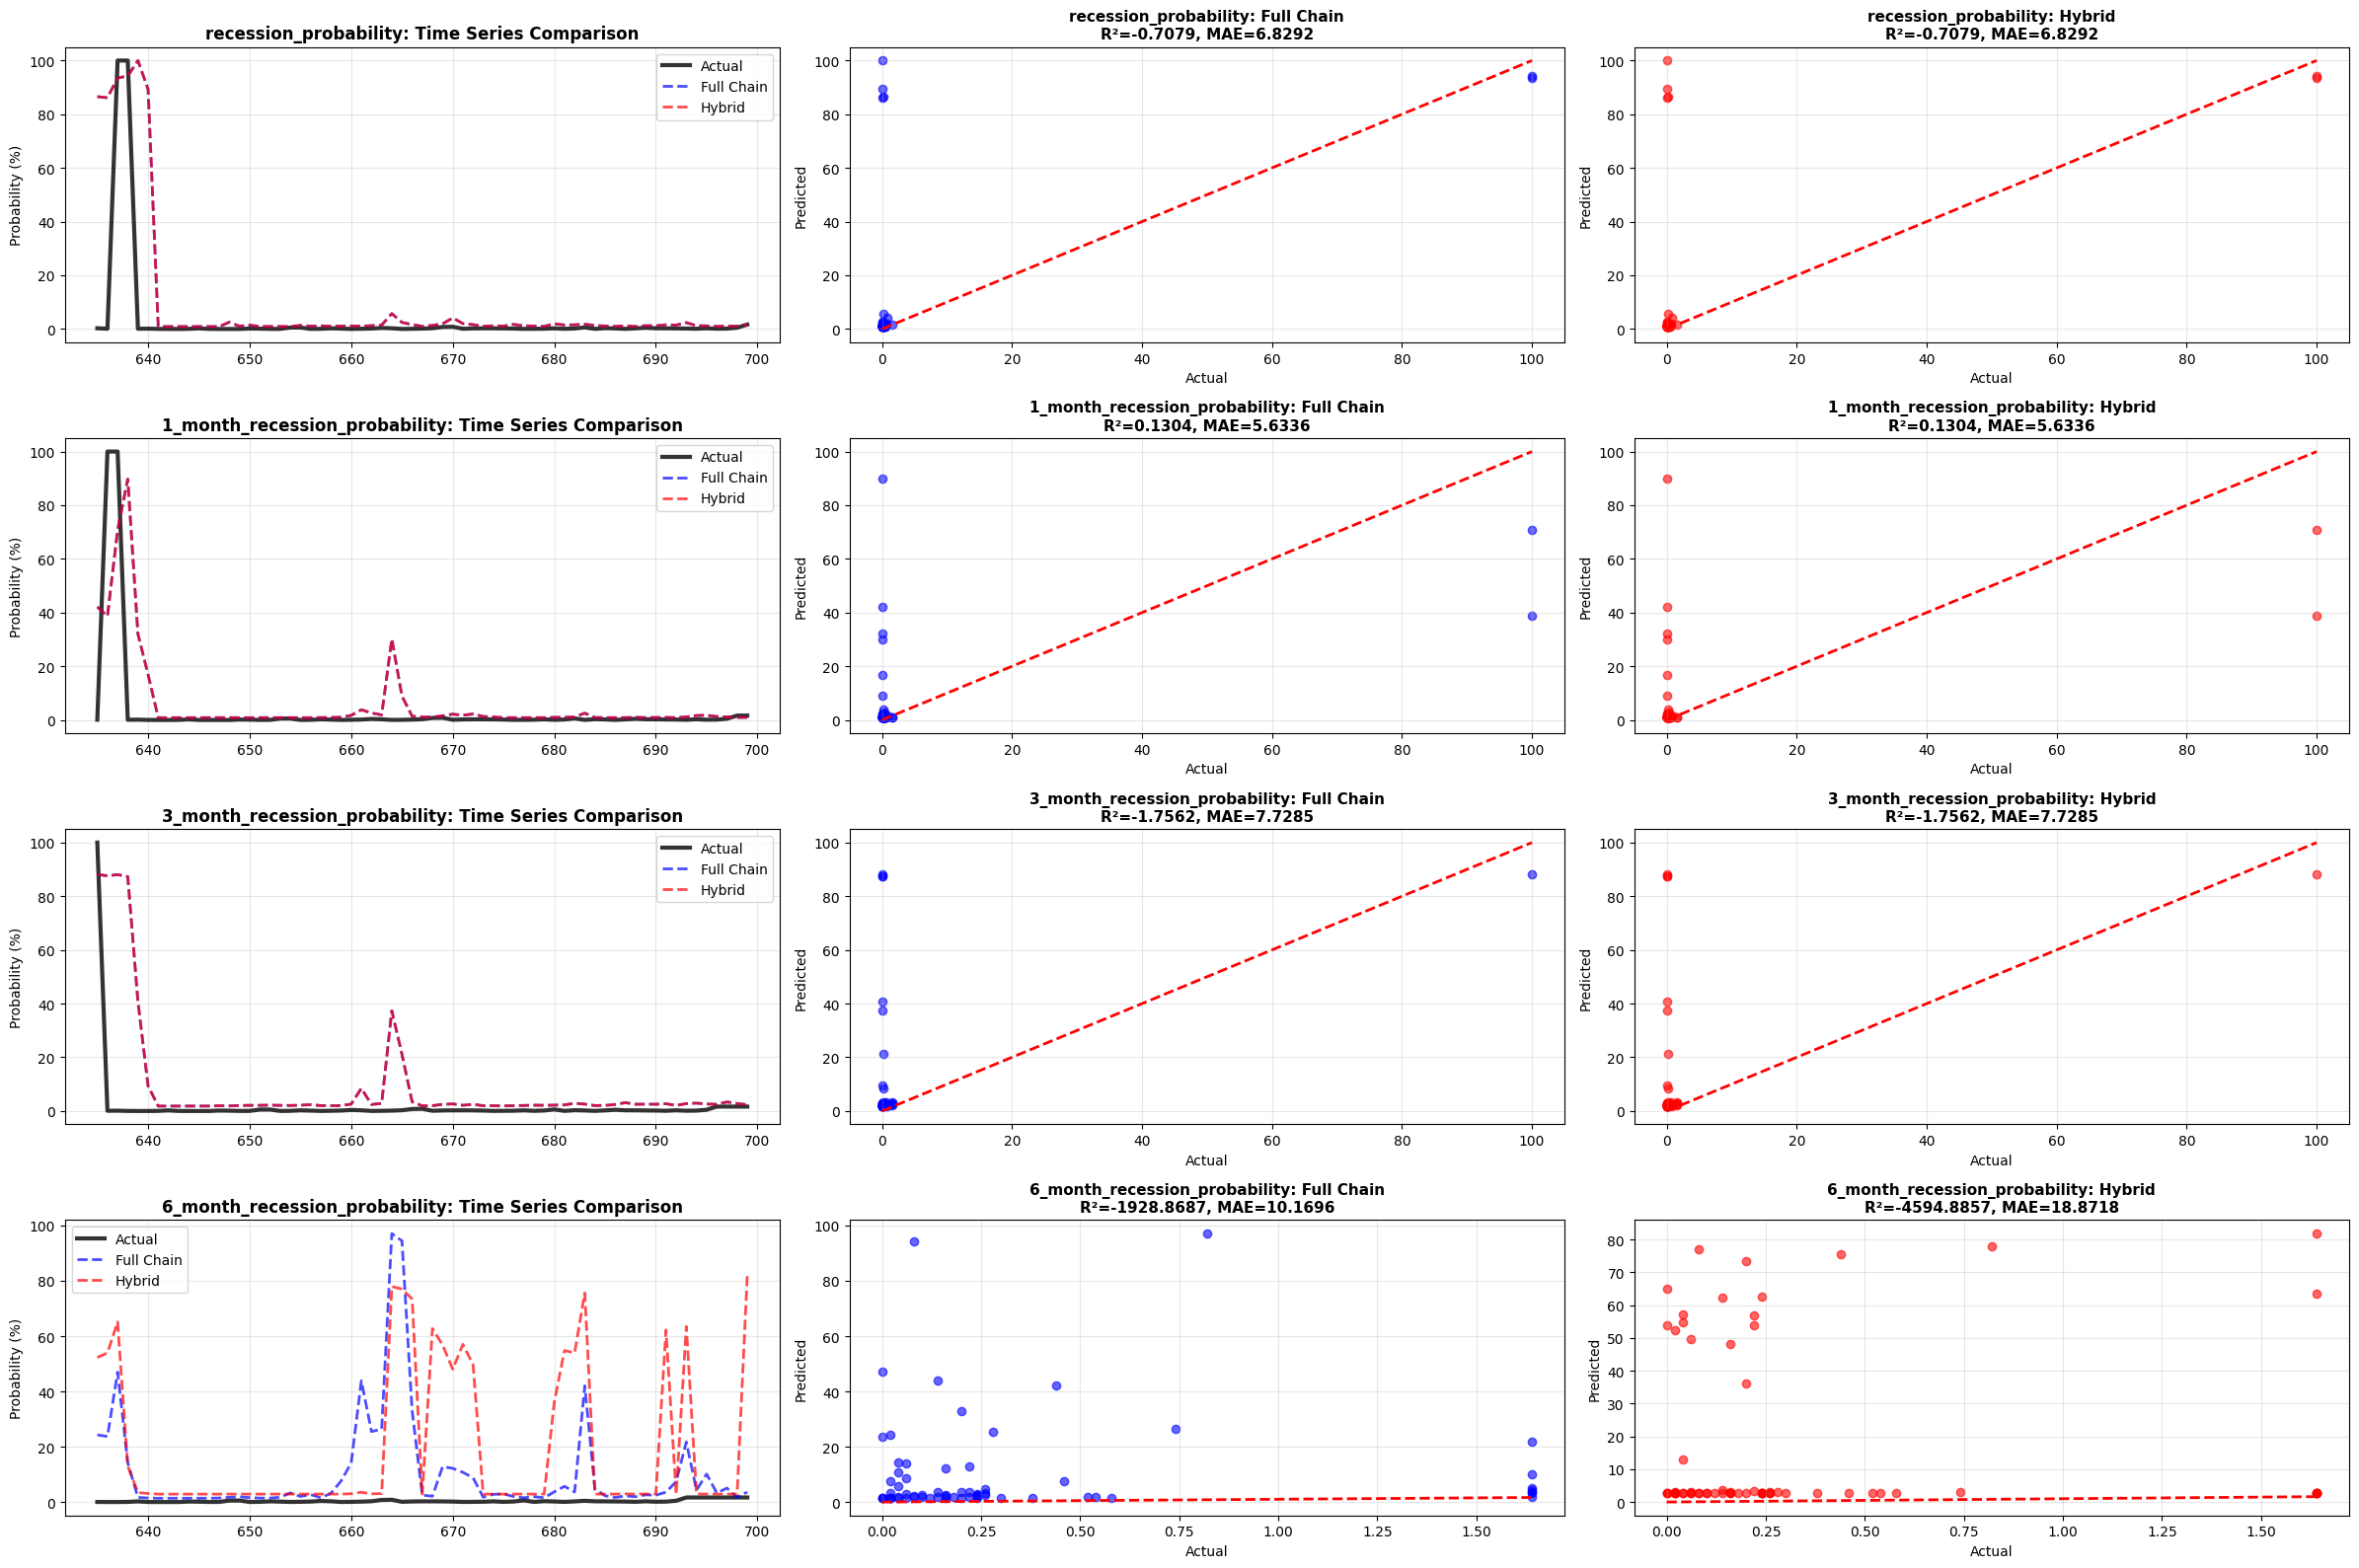

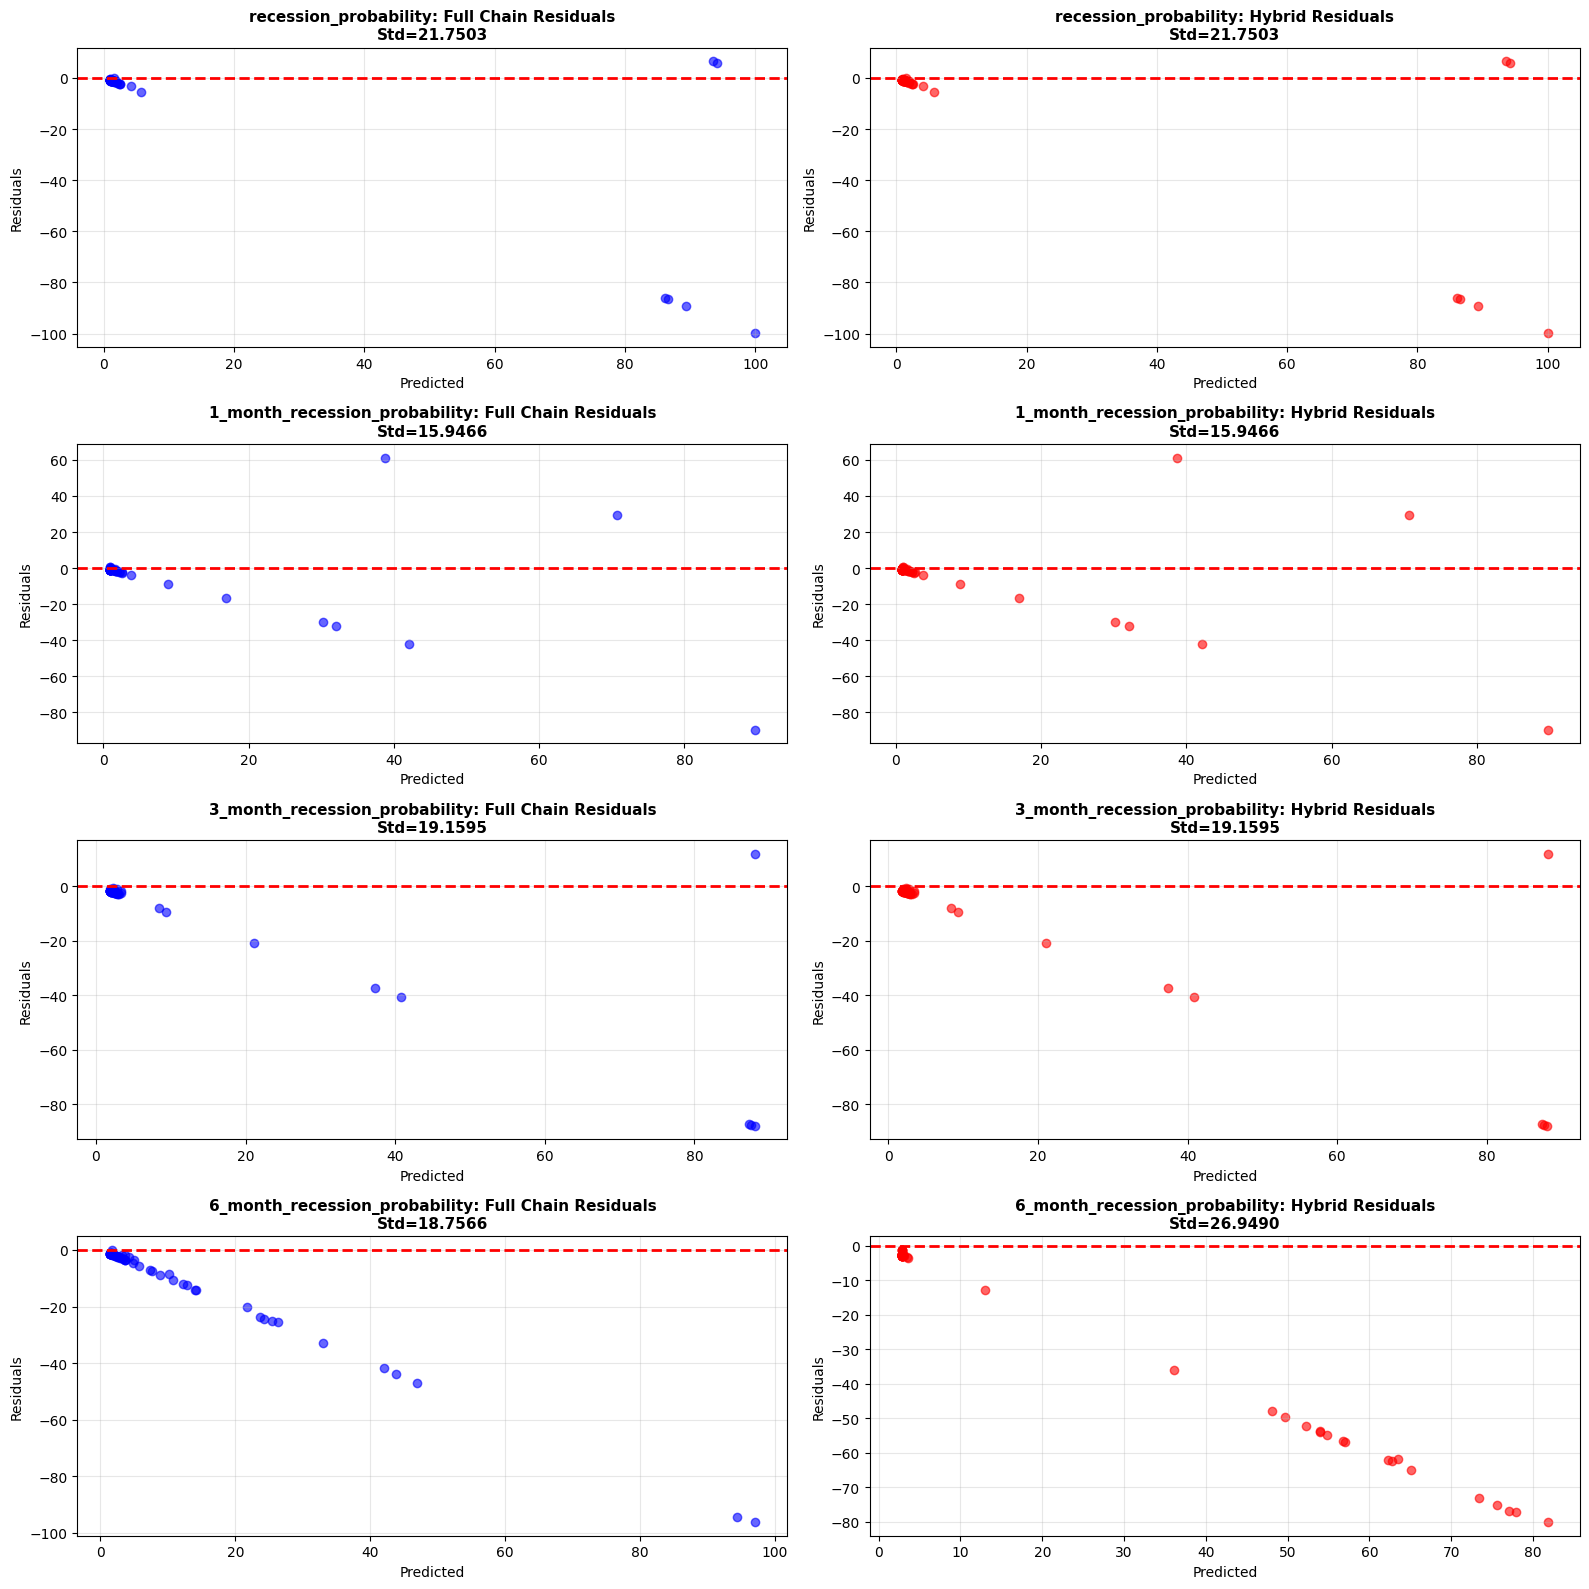


✓ Best model saved: models/full_chain_stacking.pkl (18.33 MB)
  Architecture: Full Chain
  Average MAE: 7.5902
Running architecture comparison...

[1/2] Training Full Chain...

TRAINING: Full Chain

[1/3] Training base models...
  Training CatBoost...
  Training LightGBM...
  Training RandomForest...

[2/3] Generating CV predictions...
Generating CV predictions (5 folds)...
  ✓ Completed 5 folds                    

[3/3] Training meta-models...
  recession_probability... α=0.01, R²=0.8852
  1_month_recession_probability... α=0.10, R²=0.8489
  3_month_recession_probability... α=0.50, R²=0.7533
  6_month_recession_probability... α=0.50, R²=0.8060

✓ COMPLETED: Full Chain

[2/2] Training Hybrid...

TRAINING: Hybrid

[1/3] Training base models...
  Training CatBoost...
  Training LightGBM...
  Training RandomForest...

[2/3] Generating CV predictions...
Generating CV predictions (5 folds)...
  ✓ Completed 5 folds                    

[3/3] Training meta-models...
  recession_probability.

In [61]:
# Full comparison with detailed metrics & visualizations
results = run_architecture_comparison(df)

# Save the winning model
filepath = save_best_model(results)

# Quick comparison (faster, less verbose)
quick_comparison(df)

FINAL PIPELINE (REGRESSOR CHAIN ONLY)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, RobustScaler
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import warnings
warnings.filterwarnings('ignore')

# ========================================================================================
# FULL CHAIN STACKING PIPELINE
# Single RegressorChain for all 4 targets: recession_prob → 1m → 3m → 6m
# ========================================================================================

recession_targets = [
    "recession_probability",
    "1_month_recession_probability", 
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Data Preparation
# -------------------------
def prepare_data(df, split_date="2020-01-01"):
    """Split data into train/test sets"""
    df["date"] = pd.to_datetime(df["date"])
    train_df = df[df["date"] < split_date].copy()
    test_df = df[df["date"] >= split_date].copy()
    
    X_train = train_df.drop(columns=recession_targets + ["date"])
    X_test = test_df.drop(columns=recession_targets + ["date"])
    y_train = train_df[recession_targets]
    y_test = test_df[recession_targets]
    
    return X_train, X_test, y_train, y_test, test_df

def clean_data(X_or_y):
    """Handle missing values and infinities"""
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    
    if hasattr(X_or_y, 'select_dtypes'):
        numeric_cols = X_or_y.select_dtypes(include=[np.number]).columns
        X_or_y[numeric_cols] = X_or_y[numeric_cols].fillna(X_or_y[numeric_cols].median())
    else:
        X_or_y = X_or_y.fillna(X_or_y.median())
    
    return X_or_y

def sanitize_columns(df):
    """Clean column names for LightGBM compatibility"""
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

# -------------------------
# Transformation Functions
# -------------------------
epsilon = 1e-8

def safe_logit_transform(y):
    """Transform probabilities to logit space for better modeling"""
    y_clipped = np.clip(y, 0, 100)
    y_scaled = y_clipped / 100.0
    y_scaled = np.clip(y_scaled, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def safe_inv_logit_transform(y_logit):
    """Transform predictions back from logit to probability space"""
    y_logit_clipped = np.clip(y_logit, -50, 50)
    y_prob = 1 / (1 + np.exp(-y_logit_clipped))
    return np.clip(y_prob * 100, 0, 100)

# -------------------------
# Base Model Wrappers
# -------------------------
class LGBMWrapper(BaseEstimator, RegressorMixin):
    """Scikit-learn compatible wrapper for LightGBM"""
    def __init__(self, params=None, num_boost_round=500, early_stopping_rounds=50):
        self.params = params or {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 8,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 30,
            "reg_alpha": 0.3,
            "reg_lambda": 0.3,
            "seed": 42,
            "verbose": -1,
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.model = None

    def fit(self, X, y):
        val_size = max(10, int(0.1 * len(X)))
        train_X, val_X = X[:-val_size], X[-val_size:]
        train_y, val_y = y[:-val_size], y[-val_size:]
        
        dtrain = lgb.Dataset(train_X, label=train_y)
        dval = lgb.Dataset(val_X, label=val_y, reference=dtrain)
        
        self.model = lgb.train(
            self.params, 
            dtrain, 
            num_boost_round=self.num_boost_round,
            valid_sets=[dval],
            callbacks=[lgb.early_stopping(self.early_stopping_rounds, verbose=False)]
        )
        return self

    def predict(self, X):
        return self.model.predict(X)

# ========================================================================================
# FULL CHAIN BASE MODELS
# ========================================================================================

class FullChainCatBoostModel:
    """CatBoost with RegressorChain for ALL 4 targets"""
    def __init__(self):
        self.chain_model = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Transform all 4 targets
        y_train_transformed = safe_logit_transform(y_train[recession_targets].values)
        
        # Single chain for all 4 targets: 0 → 1 → 2 → 3
        base_model = CatBoostRegressor(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            subsample=0.8,
            random_seed=42,
            loss_function="RMSE",
            verbose=False
        )
        
        self.chain_model = RegressorChain(base_model, order=[0, 1, 2, 3])
        self.chain_model.fit(X_train_scaled, y_train_transformed)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_logit = self.chain_model.predict(X_test_scaled)
        preds = safe_inv_logit_transform(preds_logit)
        
        return np.clip(preds, 0, 100)

class FullChainLightGBMModel:
    """LightGBM with RegressorChain for ALL 4 targets"""
    def __init__(self):
        self.chain_model = None
        self.scaler = None
        self.lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 8,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 30,
            "reg_alpha": 0.3,
            "reg_lambda": 0.3,
            "seed": 42,
            "verbose": -1,
        }
        
    def fit(self, X_train, y_train):
        X_train = sanitize_columns(X_train)
        
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Transform all 4 targets
        y_train_transformed = safe_logit_transform(y_train[recession_targets].values)
        
        # Single chain for all 4 targets
        chain_base = LGBMWrapper(params=self.lgb_params, num_boost_round=500)
        self.chain_model = RegressorChain(chain_base, order=[0, 1, 2, 3])
        self.chain_model.fit(X_train_scaled, y_train_transformed)
        
    def predict(self, X_test):
        X_test = sanitize_columns(X_test)
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_logit = self.chain_model.predict(X_test_scaled)
        preds = safe_inv_logit_transform(preds_logit)
        
        return np.clip(preds, 0, 100)

class FullChainRandomForestModel:
    """Random Forest with RegressorChain for ALL 4 targets"""
    def __init__(self):
        self.chain_model = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        self.scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Transform all 4 targets
        y_train_transformed = safe_logit_transform(y_train[recession_targets].values)
        
        rf_base = RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.chain_model = RegressorChain(base_estimator=rf_base, order=[0, 1, 2, 3])
        self.chain_model.fit(X_train_scaled, y_train_transformed)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        preds_logit = self.chain_model.predict(X_test_scaled)
        preds = safe_inv_logit_transform(preds_logit)
        
        return np.clip(preds, 0, 100)

# ========================================================================================
# STACKING ENSEMBLE
# ========================================================================================

class FullChainStackingEnsemble:
    """
    Stacking ensemble combining CatBoost, LightGBM, and Random Forest
    with full chain architecture
    """
    def __init__(self, cv_folds=8, use_feature_engineering=True):
        self.base_models = {
            'CatBoost': FullChainCatBoostModel,
            'LightGBM': FullChainLightGBMModel,
            'RandomForest': FullChainRandomForestModel
        }
        self.meta_models = {}
        self.cv_folds = cv_folds
        self.use_feature_engineering = use_feature_engineering
        self.meta_scaler = {}
        self.fitted_base_models = {}
            
    def _engineer_meta_features(self, *base_preds):
        """Create engineered features from base model predictions"""
        features = list(base_preds)
        
        if self.use_feature_engineering:
            # Mean prediction
            mean_pred = np.mean(base_preds, axis=0)
            features.append(mean_pred)
            
            # Weighted average (CatBoost=0.4, LightGBM=0.35, RF=0.25)
            weighted_avg = 0.4 * base_preds[0] + 0.35 * base_preds[1] + 0.25 * base_preds[2]
            features.append(weighted_avg)
            
            # Variance/disagreement
            pred_std = np.std(base_preds, axis=0)
            features.append(pred_std)
            
            # Min and Max
            features.append(np.min(base_preds, axis=0))
            features.append(np.max(base_preds, axis=0))
            
            # Pairwise differences
            for i in range(len(base_preds)):
                for j in range(i+1, len(base_preds)):
                    features.append(np.abs(base_preds[i] - base_preds[j]))
        
        return np.column_stack(features)
    
    def _get_cv_predictions(self, X_train, y_train):
        """Generate stratified cross-validation predictions"""
        recession_prob = y_train['recession_probability'].values
        bins = np.quantile(recession_prob, [0, 0.25, 0.5, 0.75, 1.0])
        stratify_labels = np.digitize(recession_prob, bins) - 1
        
        skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        
        n_samples = X_train.shape[0]
        n_targets = len(recession_targets)
        
        cv_predictions = {name: np.zeros((n_samples, n_targets)) 
                         for name in self.base_models.keys()}
        
        print(f"Generating CV predictions ({self.cv_folds} folds)...")
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, stratify_labels)):
            print(f"  Fold {fold_idx + 1}/{self.cv_folds}", end='\r')
            
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            
            for model_name, model_class in self.base_models.items():
                model = model_class()
                model.fit(X_fold_train, y_fold_train)
                cv_predictions[model_name][val_idx] = model.predict(X_fold_val)
        
        print(f"  ✓ Completed {self.cv_folds} folds" + " " * 20)
        return cv_predictions
    
    def fit(self, X_train, y_train):
        """Fit the stacking ensemble"""
        print(f"\n{'='*80}")
        print("TRAINING: FULL CHAIN STACKING ENSEMBLE")
        print("="*80)
        
        print("\n[1/3] Training base models...")
        for model_name, model_class in self.base_models.items():
            print(f"  Training {model_name}...")
            model = model_class()
            model.fit(X_train, y_train)
            self.fitted_base_models[model_name] = model
        
        print("\n[2/3] Generating CV predictions...")
        cv_predictions = self._get_cv_predictions(X_train, y_train)
        
        print("\n[3/3] Training meta-models...")
        for i, target in enumerate(recession_targets):
            print(f"  {target}...", end='')
            
            # Extract predictions for this target from all base models
            base_preds_for_target = [cv_predictions[name][:, i] 
                                    for name in self.base_models.keys()]
            
            # Create meta features
            meta_features = self._engineer_meta_features(*base_preds_for_target)
            
            # Scale
            scaler = StandardScaler()
            meta_features_scaled = scaler.fit_transform(meta_features)
            self.meta_scaler[target] = scaler
            
            # Nested CV for hyperparameter tuning
            kf_inner = KFold(n_splits=3, shuffle=True, random_state=42)
            best_score = -np.inf
            best_alpha = 0.1
            
            for alpha in [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]:
                meta_model_test = ElasticNet(alpha=alpha, l1_ratio=0.5, 
                                            random_state=42, max_iter=2000)
                cv_scores = []
                
                for train_inner_idx, val_inner_idx in kf_inner.split(meta_features_scaled):
                    meta_model_test.fit(
                        meta_features_scaled[train_inner_idx], 
                        y_train[target].values[train_inner_idx]
                    )
                    pred = meta_model_test.predict(meta_features_scaled[val_inner_idx])
                    score = r2_score(y_train[target].values[val_inner_idx], pred)
                    cv_scores.append(score)
                
                avg_score = np.mean(cv_scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_alpha = alpha
            
            # Train final meta-model
            meta_model = ElasticNet(alpha=best_alpha, l1_ratio=0.5, 
                                   random_state=42, max_iter=2000)
            meta_model.fit(meta_features_scaled, y_train[target])
            self.meta_models[target] = meta_model
            
            print(f" α={best_alpha:.2f}, R²={best_score:.4f}")
        
        print(f"\n{'='*80}")
        print("✓ TRAINING COMPLETED")
        print("="*80)
        
    def predict(self, X_test):
        """Make predictions"""
        # Get predictions from all base models
        base_predictions = {}
        for model_name, model in self.fitted_base_models.items():
            base_predictions[model_name] = model.predict(X_test)
        
        # Generate final predictions
        final_predictions = np.zeros_like(list(base_predictions.values())[0])
        
        for i, target in enumerate(recession_targets):
            # Extract predictions for this target
            base_preds_for_target = [base_predictions[name][:, i] 
                                    for name in self.base_models.keys()]
            
            # Create meta features
            meta_features = self._engineer_meta_features(*base_preds_for_target)
            meta_features_scaled = self.meta_scaler[target].transform(meta_features)
            
            # Predict
            final_predictions[:, i] = self.meta_models[target].predict(meta_features_scaled)
            
        return np.clip(final_predictions, 0, 100)

# -------------------------
# Evaluation Functions
# -------------------------
def evaluate_model(y_true, y_pred, model_name="Full Chain Stacking"):
    """Comprehensive evaluation"""
    print(f"\n{'='*80}")
    print(f"{model_name} - EVALUATION")
    print("="*80)
    
    metrics_list = []
    for i, target in enumerate(recession_targets):
        mae = mean_absolute_error(y_true[target], y_pred[:, i])
        rmse = mean_squared_error(y_true[target], y_pred[:, i], squared=False)
        r2 = r2_score(y_true[target], y_pred[:, i])
        mape = np.mean(np.abs((y_true[target] - y_pred[:, i]) / np.maximum(y_true[target], 1))) * 100
        max_error = np.max(np.abs(y_true[target] - y_pred[:, i]))
        
        metrics_list.append({
            'Target': target,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'Max_Error': max_error
        })
        
        print(f"\n{target}:")
        print(f"  MAE:        {mae:.4f}")
        print(f"  RMSE:       {rmse:.4f}")
        print(f"  R²:         {r2:.4f}")
        print(f"  MAPE:       {mape:.2f}%")
        print(f"  Max Error:  {max_error:.4f}")
    
    # Overall metrics
    avg_mae = np.mean([m['MAE'] for m in metrics_list])
    avg_rmse = np.mean([m['RMSE'] for m in metrics_list])
    avg_r2 = np.mean([m['R2'] for m in metrics_list])
    
    print(f"\n{'='*80}")
    print("OVERALL PERFORMANCE:")
    print(f"  Average MAE:  {avg_mae:.4f}")
    print(f"  Average RMSE: {avg_rmse:.4f}")
    print(f"  Average R²:   {avg_r2:.4f}")
    print("="*80)
    
    return pd.DataFrame(metrics_list)

def plot_predictions(y_test, y_pred, test_df):
    """Visualize predictions vs actual values"""
    fig, axes = plt.subplots(len(recession_targets), 2, figsize=(18, 4*len(recession_targets)))
    
    for i, target in enumerate(recession_targets):
        # Time series plot
        axes[i, 0].plot(test_df.index, y_test[target], 
                       label="Actual", linewidth=3, alpha=0.8, color='black')
        axes[i, 0].plot(test_df.index, y_pred[:, i], 
                       label="Predicted", linestyle="--", alpha=0.7, 
                       color='blue', linewidth=2)
        
        axes[i, 0].set_title(f"{target}: Time Series", fontsize=12, fontweight='bold')
        axes[i, 0].legend(loc='best')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_ylabel('Probability (%)', fontsize=10)
        
        # Scatter plot
        axes[i, 1].scatter(y_test[target], y_pred[:, i], alpha=0.6, color='blue')
        axes[i, 1].plot([y_test[target].min(), y_test[target].max()], 
                       [y_test[target].min(), y_test[target].max()], 
                       'r--', linewidth=2)
        
        mae = mean_absolute_error(y_test[target], y_pred[:, i])
        r2 = r2_score(y_test[target], y_pred[:, i])
        
        axes[i, 1].set_title(f'{target}: Predicted vs Actual\nMAE={mae:.4f}, R²={r2:.4f}', 
                            fontsize=11, fontweight='bold')
        axes[i, 1].set_xlabel('Actual', fontsize=10)
        axes[i, 1].set_ylabel('Predicted', fontsize=10)
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_residuals(y_test, y_pred):
    """Plot residual analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, target in enumerate(recession_targets):
        residuals = y_test[target] - y_pred[:, i]
        
        axes[i].scatter(y_pred[:, i], residuals, alpha=0.6, color='blue')
        axes[i].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_ylabel('Residuals', fontsize=10)
        axes[i].set_title(f'{target}: Residuals\nStd={residuals.std():.4f}', 
                         fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# -------------------------
# Save/Load Functions
# -------------------------
def save_model(model, filepath="models/full_chain_stacking.pkl"):
    """Save the trained model"""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    file_size = os.path.getsize(filepath) / (1024 * 1024)
    print(f"\n✓ Model saved: {filepath} ({file_size:.2f} MB)")
    
    return filepath

def load_model(filepath="models/full_chain_stacking.pkl"):
    """Load a trained model"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    
    print(f"✓ Model loaded from: {filepath}")
    return model

# -------------------------
# Main Training Pipeline
# -------------------------
def train_full_chain_model(df, split_date="2020-01-01", cv_folds=8, save_path=None):
    """
    Complete training pipeline for Full Chain Stacking model
    
    Args:
        df: DataFrame with features and targets
        split_date: Date to split train/test (default: "2020-01-01")
        cv_folds: Number of CV folds for meta-model training (default: 8)
        save_path: Path to save the model (default: None, will save to models/full_chain_stacking.pkl)
    
    Returns:
        model: Trained FullChainStackingEnsemble
        predictions: Test set predictions
        metrics: Evaluation metrics DataFrame
    """
    import time
    
    print("="*80)
    print("FULL CHAIN STACKING PIPELINE")
    print("="*80)
    
    # Prepare data
    print("\n[STEP 1/5] Preparing data...")
    X_train, X_test, y_train, y_test, test_df = prepare_data(df, split_date)
    X_train = clean_data(X_train)
    X_test = clean_data(X_test)
    y_train = clean_data(y_train)
    y_test = clean_data(y_test)
    
    print(f"  Training samples: {X_train.shape[0]}")
    print(f"  Test samples:     {X_test.shape[0]}")
    print(f"  Features:         {X_train.shape[1]}")
    
    # Initialize model
    print("\n[STEP 2/5] Initializing model...")
    model = FullChainStackingEnsemble(cv_folds=cv_folds, use_feature_engineering=True)
    
    # Train model
    print("\n[STEP 3/5] Training model...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"\n⏱ Training time: {train_time:.2f}s")
    
    # Make predictions
    print("\n[STEP 4/5] Making predictions...")
    start_time = time.time()
    predictions = model.predict(X_test)
    pred_time = time.time() - start_time
    print(f"⏱ Prediction time: {pred_time:.4f}s")
    
    # Evaluate
    print("\n[STEP 5/5] Evaluating model...")
    metrics = evaluate_model(y_test, predictions)
    
    # Save model
    if save_path is None:
        save_path = "models/full_chain_stacking.pkl"
    save_model(model, save_path)
    
    # Visualize
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    plot_predictions(y_test, predictions, test_df)
    plot_residuals(y_test, predictions)
    
    return model, predictions, metrics

# -------------------------
# Quick Prediction Function
# -------------------------
def predict_with_model(model, X_new):
    """
    Make predictions with a trained model
    
    Args:
        model: Trained FullChainStackingEnsemble
        X_new: New features to predict on
    
    Returns:
        predictions: Array of shape (n_samples, 4) with predictions for all targets
    """
    X_new_clean = clean_data(X_new)
    predictions = model.predict(X_new_clean)
    
    # Return as DataFrame for easier interpretation
    pred_df = pd.DataFrame(
        predictions,
        columns=recession_targets,
        index=X_new.index
    )
    
    return pred_df


# ========================================================================================
# USAGE EXAMPLES
# ========================================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("FULL CHAIN STACKING PIPELINE - USAGE EXAMPLES")
    print("="*80)
    
    print("""
    
# ============================================================
# EXAMPLE 1: Train a new model
# ============================================================

import pandas as pd

# Load your data
df = pd.read_csv('recession_data.csv')

# Train the model (this will also save it)
model, predictions, metrics = train_full_chain_model(
    df, 
    split_date="2020-01-01",
    cv_folds=8,
    save_path="models/full_chain_stacking.pkl"
)

# View metrics
print(metrics)


# ============================================================
# EXAMPLE 2: Load existing model and make predictions
# ============================================================

# Load the saved model
model = load_model("models/full_chain_stacking.pkl")

# Prepare new data
X_new = df.drop(columns=recession_targets + ["date"]).tail(10)

# Make predictions
predictions = predict_with_model(model, X_new)
print(predictions)


# ============================================================
# EXAMPLE 3: Quick training without saving
# ============================================================

# Prepare data
X_train, X_test, y_train, y_test, test_df = prepare_data(df)
X_train = clean_data(X_train)
X_test = clean_data(X_test)
y_train = clean_data(y_train)
y_test = clean_data(y_test)

# Train model
model = FullChainStackingEnsemble(cv_folds=5)  # Fewer folds for speed
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Evaluate
metrics = evaluate_model(y_test, predictions)


# ============================================================
# EXAMPLE 4: Custom evaluation on specific dates
# ============================================================

# Get predictions for a specific time period
mask = (test_df['date'] >= '2020-01-01') & (test_df['date'] <= '2021-12-31')
subset_predictions = predictions[mask]
subset_actual = y_test[mask]

# Calculate metrics for this period
for i, target in enumerate(recession_targets):
    mae = mean_absolute_error(subset_actual[target], subset_predictions[:, i])
    print(f"{target}: MAE = {mae:.4f}")

    """)
    
    print("\n" + "="*80)
    print("KEY FEATURES")
    print("="*80)
    print("""
    ✓ Full Chain Architecture: All 4 targets in single RegressorChain
    ✓ Stacking Ensemble: CatBoost + LightGBM + Random Forest
    ✓ Meta-Learning: ElasticNet with feature engineering
    ✓ Stratified CV: 8-fold cross-validation
    ✓ Logit Transform: Better probability modeling
    ✓ Automatic Hyperparameter Tuning: For meta-models
    ✓ Comprehensive Evaluation: MAE, RMSE, R², MAPE
    ✓ Visualization: Time series + scatter + residual plots
    """)


FULL CHAIN STACKING PIPELINE - USAGE EXAMPLES


# ============================================================
# EXAMPLE 1: Train a new model
# ============================================================

import pandas as pd

# Load your data
df = pd.read_csv('recession_data.csv')

# Train the model (this will also save it)
model, predictions, metrics = train_full_chain_model(
    df, 
    split_date="2020-01-01",
    cv_folds=8,
    save_path="models/full_chain_stacking.pkl"
)

# View metrics
print(metrics)


# ============================================================
# EXAMPLE 2: Load existing model and make predictions
# ============================================================

# Load the saved model
model = load_model("models/full_chain_stacking.pkl")

# Prepare new data
X_new = df.drop(columns=recession_targets + ["date"]).tail(10)

# Make predictions
predictions = predict_with_model(model, X_new)
print(predictions)


# ====================================================

FULL CHAIN STACKING PIPELINE

[STEP 1/5] Preparing data...
  Training samples: 635
  Test samples:     65
  Features:         46

[STEP 2/5] Initializing model...

[STEP 3/5] Training model...

TRAINING: FULL CHAIN STACKING ENSEMBLE

[1/3] Training base models...
  Training CatBoost...
  Training LightGBM...
  Training RandomForest...

[2/3] Generating CV predictions...
Generating CV predictions (8 folds)...
  ✓ Completed 8 folds                    

[3/3] Training meta-models...
  recession_probability... α=0.01, R²=0.8960
  1_month_recession_probability... α=0.01, R²=0.8821
  3_month_recession_probability... α=0.50, R²=0.7751
  6_month_recession_probability... α=0.10, R²=0.7878

✓ TRAINING COMPLETED

⏱ Training time: 35.69s

[STEP 4/5] Making predictions...
⏱ Prediction time: 0.1242s

[STEP 5/5] Evaluating model...

Full Chain Stacking - EVALUATION

recession_probability:
  MAE:        6.8292
  RMSE:       22.5250
  R²:         -0.7079
  MAPE:       664.16%
  Max Error:  99.9200

1_m

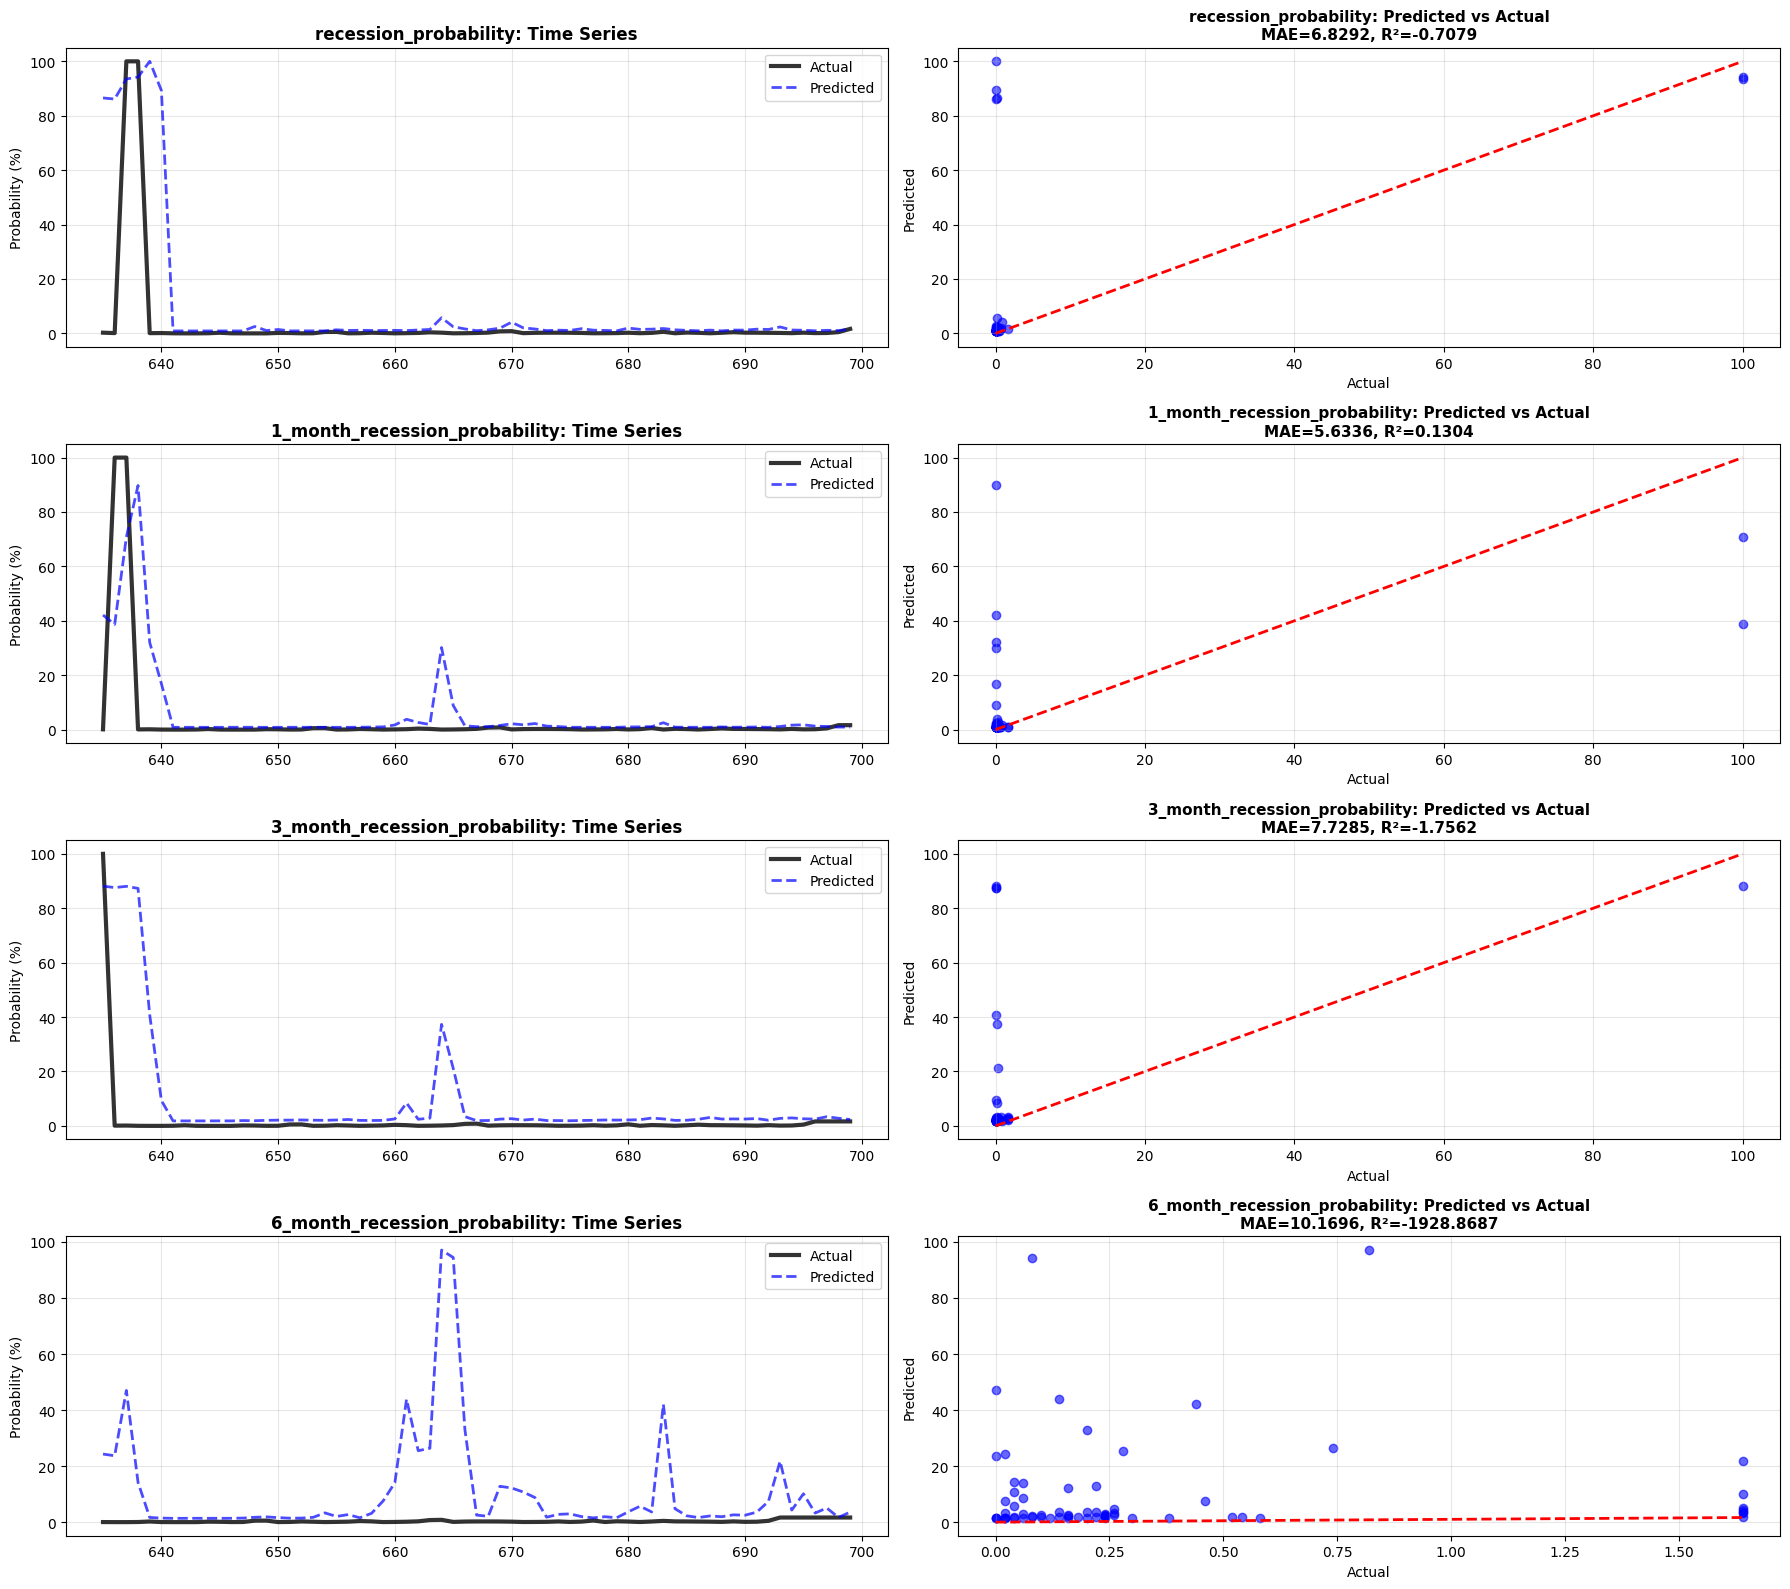

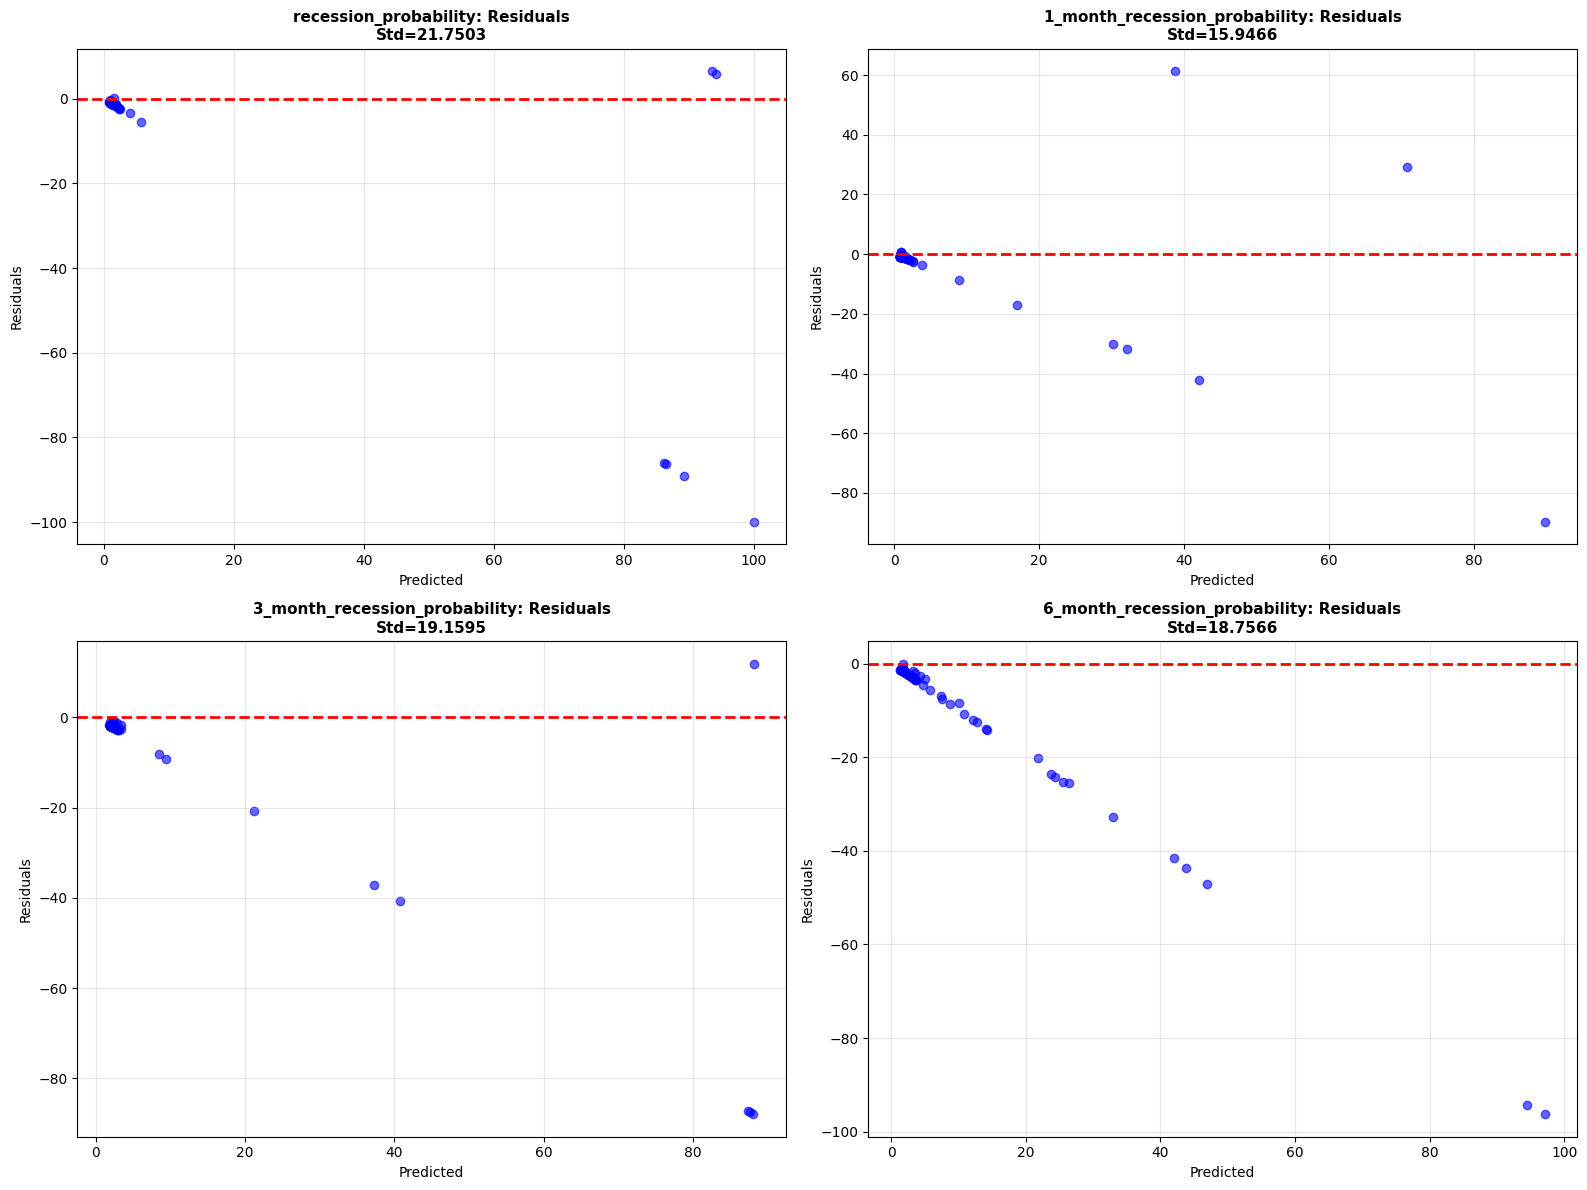

In [63]:
import pandas as pd

# Load your data
df = pd.read_csv('../data/fix/feature_selected_reg_full.csv')

# Train the model - this does everything!
model, predictions, metrics = train_full_chain_model(df)